In [2]:
import pandas as pd
import os # ファイルの存在確認用

# --- ファイルパスの定義（ここをご自身の環境に合わせて変更してください） ---
# 例: Colabの左側のフォルダマークにアップロードした場合のパス
CSV_PATH_BAT = 'stats_bat.csv' 
CSV_PATH_PLAYERS = 'players.csv'
# ------------------------------------------------------------------

print("1. データの読み込みと処理を開始します...")

# ファイルの存在確認
if not os.path.exists(CSV_PATH_BAT) or not os.path.exists(CSV_PATH_PLAYERS):
    print(f"\n【エラー】指定されたパスにファイルが見つかりません。")
    print(f"stats_bat.csv のパス: {os.path.abspath(CSV_PATH_BAT)}")
    print(f"players.csv のパス: {os.path.abspath(CSV_PATH_PLAYERS)}")
    print("パスが正しいか確認し、ファイルを配置してください。")
    exit()

# データの読み込み（文字コード判別対応）
def load_csv_data(filepath):
    # Shift-JIS, CP932, UTF-8 の順でエンコーディングを試行
    for enc in ['shift_jis', 'cp932', 'utf-8']:
        try:
            df = pd.read_csv(filepath, encoding=enc)
            print(f"  -> {os.path.basename(filepath)} を {enc} で読み込み成功。")
            return df
        except UnicodeDecodeError:
            continue
    raise UnicodeDecodeError(f"すべてのエンコーディングで {os.path.basename(filepath)} の読み込みに失敗しました。")

try:
    stats_bat = load_csv_data(CSV_PATH_BAT)
    players = load_csv_data(CSV_PATH_PLAYERS)
except UnicodeDecodeError as e:
    print(f"\n【重大エラー】{e}")
    exit()

# --- データ加工処理 ---

# 1. 選手データからドラフト年度を一意に抽出
player_meta = players[['player_id', 'draft_year']].drop_duplicates(subset=['player_id'])

# ドラフト年度を数値化（エラーはNaNにする）
player_meta['draft_year'] = pd.to_numeric(player_meta['draft_year'], errors='coerce')
player_meta = player_meta.dropna(subset=['draft_year'])

# 2. 成績データと結合
# 'stats_bat.csv'に成績年度を示すカラム名が 'season_year' であることを前提としています。
if 'season_year' not in stats_bat.columns:
    print("\n【エラー】'stats_bat.csv'に成績年度を示す 'season_year' カラムが見つかりません。")
    print(f"見つかったカラム: {stats_bat.columns.tolist()}")
    exit()
    
df = pd.merge(stats_bat, player_meta, on='player_id', how='inner')

# 3. プロ年数の計算 (成績年度 - ドラフト年)
df['pro_year'] = df['season_year'] - df['draft_year']

# 4. フィルタリング

# 条件A: プロ5年目以上
df_active = df[df['pro_year'] >= 5]

# 条件B: 規定打席444打席以上
df_active = df_active[df_active['pa'] >= 444]

# 条件C: 打率.250以上
# 打数が0でないデータのみを対象とし、打率を計算
df_active = df_active[df_active['ab'] > 0].copy()
df_active['avg'] = df_active['h'] / df_active['ab']
df_active = df_active[df_active['avg'] >= 0.250]

# 5. 出力用データの整形
output_columns = [
    'player_id', 'season_year', 'player_name', 'team_name',
    'pro_year', 'avg', 'g', 'pa', 'ab', 'h', 'hr', 'rbi', 'so', 'bb', 'sb'
]

# 該当する列が存在するか確認してから抽出（存在しない列はスキップ）
existing_cols = [col for col in output_columns if col in df_active.columns]
df_clean = df_active[existing_cols].copy()

# 打率を3桁で丸める
if 'avg' in df_clean.columns:
    df_clean['avg'] = df_clean['avg'].round(3)

# 並び替え（プロ年数 降順 -> 打率 降順）
df_clean = df_clean.sort_values(by=['pro_year', 'avg'], ascending=[False, False])

# CSV保存
output_filename = 'pro_baseball_analysis_data.csv'
df_clean.to_csv(output_filename, index=False, encoding='utf-8-sig')

print(f"\n2. 処理完了。'{output_filename}' に結果を保存しました。")
print(f"抽出件数: {len(df_clean)} 件")

# --- 分析: それを達成したのはプロ何年目が多いか？ ---
print("\n-----------------------------------------------------")
print("⚾ プロ何年目での達成が多いか（件数集計）")
if len(df_clean) > 0:
    year_counts = df_clean['pro_year'].value_counts().sort_index()
    print(year_counts)
else:
    print("抽出件数が0のため集計できませんでした。")

1. データの読み込みと処理を開始します...
  -> stats_bat.csv を cp932 で読み込み成功。
  -> players.csv を cp932 で読み込み成功。

2. 処理完了。'pro_baseball_analysis_data.csv' に結果を保存しました。
抽出件数: 139 件

-----------------------------------------------------
⚾ プロ何年目での達成が多いか（件数集計）
pro_year
5.0     23
6.0     19
7.0     18
8.0     12
9.0      9
10.0    15
11.0     9
12.0     9
13.0     8
14.0     6
15.0     4
16.0     2
17.0     2
18.0     1
20.0     2
Name: count, dtype: int64


/var/folders/z5/lfgh614s4n73_k8hprrh_fzh0000gn/T/ipykernel_4959/2160705161.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_rounds.index, y=top_rounds.values, palette="rocket")
findfont: Generic family 'sans-serif' not found because none of the following families were found: IPAexGothic, Noto Sans CJK JP, Meiryo, TakaoGothic
findfont: Generic family 'sans-serif' not found because none of the following families were found: IPAexGothic, Noto Sans CJK JP, Meiryo, TakaoGothic
/var/folders/z5/lfgh614s4n73_k8hprrh_fzh0000gn/T/ipykernel_4959/2160705161.py:143: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
findfont: Generic family 'sans-serif' not found because none of the following families were found: IPAexGothic, Noto Sans CJK JP, Meiryo, TakaoGothic
findfont: Gener

1. データの読み込みと処理を開始します...
  -> stats_bat.csv を cp932 で読み込み成功。
  -> players.csv を cp932 で読み込み成功。

2. 処理完了。'pro_baseball_analysis_data.csv' に結果を保存しました。
抽出件数: 139 件

-----------------------------------------------------
⚾ プロ何年目での達成が多いか（件数集計）
pro_year
5.0     23
6.0     19
7.0     18
8.0     12
9.0      9
10.0    15
11.0     9
12.0     9
13.0     8
14.0     6
15.0     4
16.0     2
17.0     2
18.0     1
20.0     2
Name: count, dtype: int64

-----------------------------------------------------
🏆 ドラフト順位 (draft_round) 別 活躍事例の件数集計
（プロ5年目以降、規定打席達成、打率.250以上の件数）
draft_round
10位        2
1位        39
2位        20
2巡目        1
3位        20
4位        17
4巡目        2
5位        14
6位         7
7位         4
9位         5
（育）2位      1
（育）5位      1
（高）1巡目     2
（高）3巡目     4
Name: count, dtype: int64


findfont: Generic family 'sans-serif' not found because none of the following families were found: IPAexGothic, Noto Sans CJK JP, Meiryo, TakaoGothic
findfont: Generic family 'sans-serif' not found because none of the following families were found: IPAexGothic, Noto Sans CJK JP, Meiryo, TakaoGothic
findfont: Generic family 'sans-serif' not found because none of the following families were found: IPAexGothic, Noto Sans CJK JP, Meiryo, TakaoGothic
findfont: Generic family 'sans-serif' not found because none of the following families were found: IPAexGothic, Noto Sans CJK JP, Meiryo, TakaoGothic
findfont: Generic family 'sans-serif' not found because none of the following families were found: IPAexGothic, Noto Sans CJK JP, Meiryo, TakaoGothic
/var/folders/z5/lfgh614s4n73_k8hprrh_fzh0000gn/T/ipykernel_4959/2160705161.py:143: UserWarning: Glyph 12489 (\N{KATAKANA LETTER DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/z5/lfgh614s4n73_k8hprrh_fzh0000gn/T/ipykernel_495

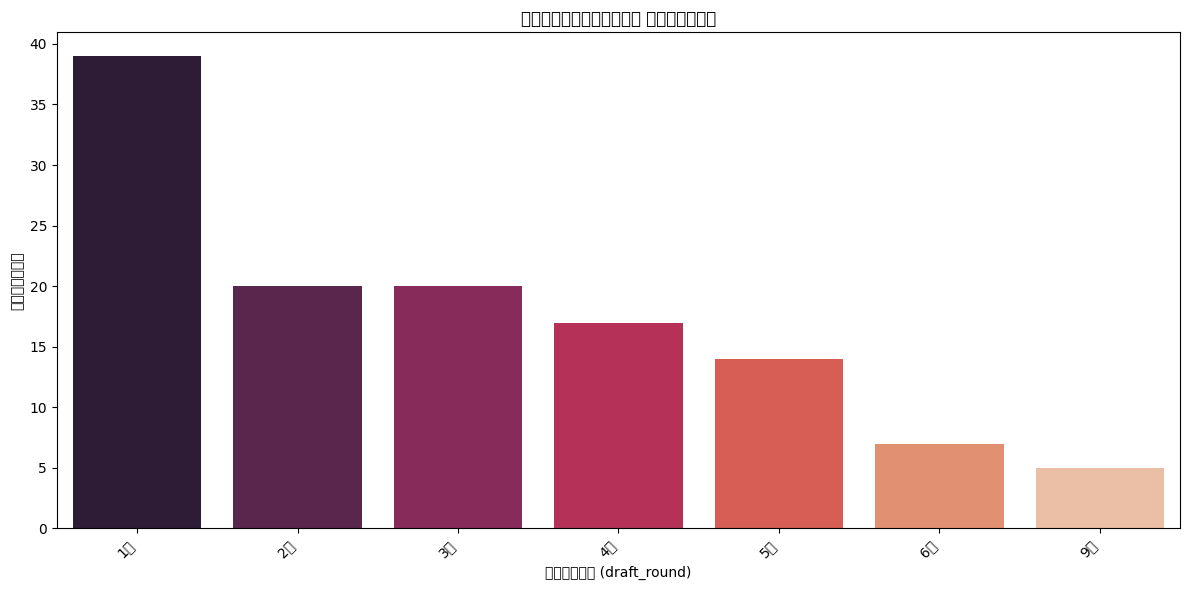

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns # グラフ描画用

# 日本語表示の設定 (Colab/Jupyter環境向け)
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.sans-serif'] = ['IPAexGothic', 'Noto Sans CJK JP', 'Meiryo', 'TakaoGothic']
plt.rcParams['axes.unicode_minus'] = False 

# --- ファイルパスの定義（ここをご自身の環境に合わせて変更してください） ---
CSV_PATH_BAT = 'stats_bat.csv' 
CSV_PATH_PLAYERS = 'players.csv'
# ------------------------------------------------------------------

print("1. データの読み込みと処理を開始します...")

# ファイルの存在確認
if not os.path.exists(CSV_PATH_BAT) or not os.path.exists(CSV_PATH_PLAYERS):
    print(f"\n【エラー】指定されたパスにファイルが見つかりません。")
    print("パスが正しいか確認し、ファイルを配置してください。")
    exit()

# データの読み込み（文字コード判別対応）
def load_csv_data(filepath):
    for enc in ['shift_jis', 'cp932', 'utf-8']:
        try:
            df = pd.read_csv(filepath, encoding=enc)
            print(f"  -> {os.path.basename(filepath)} を {enc} で読み込み成功。")
            return df
        except UnicodeDecodeError:
            continue
    raise UnicodeDecodeError(f"すべてのエンコーディングで {os.path.basename(filepath)} の読み込みに失敗しました。")

try:
    stats_bat = load_csv_data(CSV_PATH_BAT)
    players = load_csv_data(CSV_PATH_PLAYERS)
except UnicodeDecodeError as e:
    print(f"\n【重大エラー】{e}")
    exit()

# --- データ加工処理 ---

# 1. 選手データからドラフト年度と順位を一意に抽出 (★修正・追加点)
# draft_roundをそのまま文字列として結合に使用
player_meta = players[['player_id', 'draft_year', 'draft_round']].drop_duplicates(subset=['player_id'])

# ドラフト年度を数値化（エラーはNaNにする）
player_meta['draft_year'] = pd.to_numeric(player_meta['draft_year'], errors='coerce')
player_meta = player_meta.dropna(subset=['draft_year'])

# 2. 成績データと結合
if 'season_year' not in stats_bat.columns:
    print("\n【エラー】'stats_bat.csv'に成績年度を示す 'season_year' カラムが見つかりません。")
    print(f"見つかったカラム: {stats_bat.columns.tolist()}")
    exit()
    
# ドラフト順位情報も一緒に結合する
df = pd.merge(stats_bat, player_meta, on='player_id', how='inner')

# 3. プロ年数の計算 (成績年度 - ドラフト年)
df['pro_year'] = df['season_year'] - df['draft_year']

# 4. フィルタリング (★元の処理と変更なし)
# 条件A: プロ5年目以上
df_active = df[df['pro_year'] >= 5]
# 条件B: 規定打席444打席以上
df_active = df_active[df_active['pa'] >= 444]
# 条件C: 打率.250以上
df_active = df_active[df_active['ab'] > 0].copy()
df_active['avg'] = df_active['h'] / df_active['ab']
df_active = df_active[df_active['avg'] >= 0.250]

# 5. 出力用データの整形 (★draft_roundを追加)
output_columns = [
    'player_id', 'season_year', 'player_name', 'team_name',
    'pro_year', 'avg', 'g', 'pa', 'ab', 'h', 'hr', 'rbi', 'so', 'bb', 'sb', 
    'draft_round' # draft_roundを追加
]

existing_cols = [col for col in output_columns if col in df_active.columns]
df_clean = df_active[existing_cols].copy()

if 'avg' in df_clean.columns:
    df_clean['avg'] = df_clean['avg'].round(3)

df_clean = df_clean.sort_values(by=['pro_year', 'avg'], ascending=[False, False])

# CSV保存
output_filename = 'pro_baseball_analysis_data.csv'
df_clean.to_csv(output_filename, index=False, encoding='utf-8-sig')

print(f"\n2. 処理完了。'{output_filename}' に結果を保存しました。")
print(f"抽出件数: {len(df_clean)} 件")

# --- 分析: 活躍事例の件数集計（プロ年数別） ---
print("\n-----------------------------------------------------")
print("⚾ プロ何年目での達成が多いか（件数集計）")
if len(df_clean) > 0:
    year_counts = df_clean['pro_year'].value_counts().sort_index()
    print(year_counts)
else:
    print("抽出件数が0のため集計できませんでした。")


# --- 新規追加分析: ドラフト順位 (draft_round) 別 活躍事例の件数集計 ---
print("\n-----------------------------------------------------")
print("🏆 ドラフト順位 (draft_round) 別 活躍事例の件数集計")

if 'draft_round' in df_clean.columns and len(df_clean) > 0:
    
    # draft_round の文字列値ごとに件数をカウント
    round_counts = df_clean['draft_round'].value_counts()
    
    # 順位 (文字列) を数値部分でソートするために変換（例: '1' < '10' < '2' となるのを防ぐ）
    # 数値順位 ('1', '2', ...) とその他 ('育1', '外'など) を分離
    
    # 数値順位の抽出
    numerical_ranks = pd.to_numeric(round_counts.index, errors='coerce').dropna().astype(int)
    numerical_counts = round_counts[numerical_ranks.astype(str)].sort_index()

    # 非数値順位の抽出（育成、外など）
    non_numerical_ranks = round_counts[round_counts.index.difference(numerical_ranks.astype(str))]
    
    # 全ての順位を結合（数値順位 + その他）
    # 数値順位の表示が優先されるようソート
    sorted_counts = pd.concat([numerical_counts, non_numerical_ranks]).sort_index()
    
    print("（プロ5年目以降、規定打席達成、打率.250以上の件数）")
    print(sorted_counts)
    
    # --- グラフ描画 ---
    plt.figure(figsize=(12, 6))
    
    # グラフを見やすくするため、件数が5件以上の順位に限定して表示 (調整可能)
    top_rounds = sorted_counts[sorted_counts >= 5]
    
    sns.barplot(x=top_rounds.index, y=top_rounds.values, palette="rocket")
    plt.title('ドラフト順位（文字列）別 活躍事例の件数')
    plt.xlabel('ドラフト順位 (draft_round)')
    plt.ylabel('活躍事例の件数')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    

else:
    print("抽出件数が0件、または 'draft_round' カラムがないため、ドラフト順位別分析はスキップされました。")